In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import pickle
import json
import copy
import time

# from alphabet_conversion import Alphabet_Converter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import warnings

warnings.filterwarnings("ignore")
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

# check GPU and torch version
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nINFO:")
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
print("GPU State:", device, "\n")

# hyper parameters
BATCH_SIZE = 1
num_workers = 1
SOS_token = 0
vocab_size = 27
hidden_size = 256
lr = 0.01
teacher_forcing_ratio = 0.8


# load .json
def load_json(path):
    with open(path, "r") as file:
        json_dict = json.load(open(path, "r"))
    _inputs = [i for _dict in json_dict for i in _dict["input"]]
    _outputs = [_dict["target"] for _dict in json_dict for i in _dict["input"]]
    return _inputs, _outputs


def dataloader(x, y):
    data = []
    for i, (batch_x, batch_y) in enumerate(zip(x, y)):
        data.append([batch_x, batch_y])
    return data

/home/deepcat/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



INFO:
PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121
GPU State: cuda 



In [2]:
import json
import random
import numpy as np
import torch
from torch.autograd import Variable


class Alphabet_Converter(object):
    def __init__(self):
        self.char2idx = {}
        self.idx2char = {}
        self.start_idx = len(self.char2idx)
        self.max_length = 0
        self.word_list = []

    def alphabet_to_category(self, dataset):
        for word in dataset:
            self.word_list.append(word)
            if self.max_length < len(word):
                self.max_length = len(word)

        all_chars = sorted(set([w for word in dataset for w in word]))
        for char in all_chars:
            self.char2idx[char] = self.start_idx
            self.idx2char[self.start_idx] = char
            self.start_idx += 1

    def word_to_indices(self, word):
        index_word = []
        for char in [char for char in word]:
            index_word.append(self.char2idx[char])
        return index_word

    def indices_to_word(self, indices):
        word = ""
        for idx in indices:
            char = self.idx2char[idx]
            word += char
        return word

    def __str__(self):
        str = "Vocab information:\n"
        for idx, char in self.idx2char.items():
            str += "Char: %s Index: %d\n" % (char, idx)
        return str

In [3]:
# bleu-4 score function
def bleu4_score(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33, 0.33, 0.33)
    else:
        weights = (0.25, 0.25, 0.25, 0.25)
    return sentence_bleu(
        [reference], output, weights=weights, smoothing_function=cc.method1
    )


# word to indices, return as .tensor
def embedding(x_word, y_word, converter):
    x_indices_word = torch.Tensor([converter.word_to_indices(x_word)])
    y_indices_word = torch.Tensor(converter.word_to_indices(y_word))
    return x_indices_word, y_indices_word


# Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)  # set up embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size)  # set up LSTM

    def forward(self, input, hidden):  # forward propagation
        embedded = self.embedding(input).permute(1, 0, 2)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self, sample_num):  # initiate hidden cell
        hidden_cell = (
            torch.zeros(1, sample_num, self.hidden_size, device=device),
            torch.zeros(1, sample_num, self.hidden_size, device=device),
        )
        return hidden_cell


# Decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)  # set up embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size)  # set up LSTM
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):  # forward propagation
        output = self.embedding(input).permute(1, 0, 2)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):  # initiate hidden cell
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [4]:
def train(
    input_tensor,
    target_tensor,
    target_words,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    encoder_optz_scheduler,
    decoder_optz_scheduler,
    criterion,
):
    encoder_hidden = encoder.initHidden(len(input_tensor))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss, score = 0, 0
    results = []

    # ----------sequence to sequence part for encoder----------#
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    # ----------sequence to sequence part for decoder----------#
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top = decoder_output.topk(1)

            decoder_input = target_tensor[di].view(1, 1)  # Teacher forcing
            loss += criterion(decoder_output, target_tensor[di].view(1))

            results.append(top.squeeze(-1).tolist())
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden
            )  # (4,1), (4,29)
            _, top = decoder_output.topk(1)

            decoder_input = top
            loss += criterion(decoder_output, target_tensor[di].view(1))

            results.append(top.squeeze(-1).tolist())

    word = alp_convert.indices_to_word(
        sum(results, [])
    )  # convert indices from prediction to word
    score += bleu4_score(word, target_words)  # collect the blue4 score

    loss.backward()  # back propagation
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / (target_length), word, score


def evaluate(input_tensor, target_tensor, target_words, encoder, decoder, criterion):
    with torch.no_grad():
        encoder_hidden = encoder.initHidden(len(input_tensor))

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        loss, score = 0, 0
        results = []
        correct_predictions = 0

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top = decoder_output.topk(1)

            decoder_input = top
            loss += criterion(decoder_output, target_tensor[di].view(1))

            results.append(top.squeeze(-1).tolist())

            # Check if the prediction is correct
            if top.item() == target_tensor[di].item():
                correct_predictions += 1

        word = alp_convert.indices_to_word(
            sum(results, [])
        )  # convert indices from prediction to word
        score += bleu4_score(word, target_words)

        # Calculate accuracy
        accuracy = correct_predictions / target_length
    return (
        loss.item() / (target_length),
        word,
        score,
        accuracy,
    )  # return training loss, predictied word, blue4 score

In [5]:
# Optimizers of encoder and decoder
def Optimizers(encoder, decoder, lr):
    encoder_optim = optim.SGD(encoder.parameters(), lr=lr)
    decoder_optim = optim.SGD(decoder.parameters(), lr=lr)
    return encoder_optim, decoder_optim


# Learning scheduler of encoder and decoder
def Scheduler(encoder_optim, decoder_optim, step_size=100, gamma=0.5):
    encoder_stepLR = StepLR(encoder_optim, step_size=step_size, gamma=gamma)
    decoder_stepLR = StepLR(decoder_optim, step_size=step_size, gamma=gamma)
    return encoder_stepLR, decoder_stepLR


# Main training process
def trainIters(x_train, y_train, n_iters, encoder, decoder, print_interval=1000):
    start = time.time()
    n_iters = n_iters
    best_score = -1

    all_training_loss, all_testing_score = [], []

    total_data = dataloader(x_train, y_train)
    training_pairs = [random.choice(total_data) for i in range(n_iters)]

    encoder_optimizer, decoder_optimizer = Optimizers(encoder, decoder, lr)
    encoder_optz_scheduler, decoder_optz_scheduler = Scheduler(
        encoder_optimizer, decoder_optimizer
    )

    criterion = nn.CrossEntropyLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        encoder.train()
        decoder.train()

        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        inputs, labels = embedding(input_tensor, target_tensor, alp_convert)
        inputs, labels = (
            Variable(inputs.to(device)).long(),
            Variable(labels.to(device)).long(),
        )

        loss, word, score = train(
            inputs,
            labels,
            target_tensor,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            encoder_optz_scheduler,
            decoder_optz_scheduler,
            criterion,
        )
        all_training_loss.append(loss)

        # evaluation every certain times using the testing set
        if iter % print_interval == 0:
            encoder.eval()
            decoder.eval()

            testing_score = 0.0
            testing_loss = 0.0
            testing_accuracy = 0.0

            # make prediction using testiing
            for i, (x, y) in enumerate(zip(x_test, y_test)):
                inputs, labels = embedding(x, y, alp_convert)
                inputs, labels = (
                    Variable(inputs.to(device)).long(),
                    Variable(labels.to(device)).long(),
                )

                loss, word, score, accuracy = evaluate(
                    inputs, labels, y, encoder, decoder, criterion
                )
                print(
                    "True word: %-20s || Predicted word: %-20s" % (y, word)
                )  # print result
                testing_score += score
                testing_loss += loss
                testing_accuracy += accuracy

            testing_score = round(testing_score / len_test, 4)
            testing_loss = round(testing_loss / len_test, 4)
            testing_accuracy = round(testing_accuracy / len_test, 4)

            # print testing lost and blue4 score
            print(
                "\n>> testing's loss: %.4f \n>> bleu-4 score: %.4f \n>> accuracy score: %.4f\n"
                % (testing_loss, testing_score, testing_accuracy)
            )

            all_testing_score.append(testing_score)

            # update the best weights
            if testing_score > best_score:
                best_encoder_weights = copy.deepcopy(encoder.state_dict())
                best_decoder_weights = copy.deepcopy(decoder.state_dict())
                best_score = testing_score

    # save the training loss & testing bleu-4 score during training
    np.save("training_process/training_loss", np.array(all_training_loss))
    np.save("training_process/testing_bleu4", np.array(all_testing_score))

    # save best weights of encoder & decoder
    torch.save(best_encoder_weights, f"weights/best_encoder_weight")
    torch.save(best_decoder_weights, f"weights/best_decoder_weight")


# make new prediction using the best weight that we trained
def predict(x_inputs, y_inputs, best_encoder, best_decoder):
    best_encoder.load_state_dict(
        torch.load("weights/best_encoder_weight")
    )  # load the best weight of encoder
    best_decoder.load_state_dict(
        torch.load("weights/best_decoder_weight")
    )  # load the best weight of decoder
    criterion = nn.CrossEntropyLoss()
    predicted_score = 0.0
    predicted_loss = 0.0
    predicted_accuracy = 0.0

    for i, (x, y) in enumerate(zip(x_inputs, y_inputs)):  # make prediction
        inputs, labels = embedding(x, y, alp_convert)
        inputs, labels = (
            Variable(inputs.to(device)).long(),
            Variable(labels.to(device)).long(),
        )

        loss, word, score, accuracy = evaluate(
            inputs, labels, y, best_encoder, best_decoder, criterion
        )
        print("True word: %-20s || Predicted word: %-20s" % (y, word))
        predicted_score += score
        predicted_loss += loss
        predicted_accuracy += accuracy

    final_bleu4 = predicted_score / len(x_inputs)
    final_loss = predicted_loss / len(x_inputs)
    final_accuracy = predicted_accuracy / len(x_inputs)

    print("\n>> bleu-4 score: %.4f" % final_bleu4)  # print blue4 score
    print("\n>> accuracy score: %.4f" % final_accuracy)  # print accuracy score
    # print("\n>> loss score: %.4f" % final_loss)  # print loss score


# load train.json & test.json
x_train, y_train = load_json("./data/train.json")
x_test, y_test = load_json("./data/test.json")
len_train = len(x_train)
len_test = len(x_test)

# start alphabet converion using the inputs of training set
alp_convert = Alphabet_Converter()
alp_convert.alphabet_to_category(x_train)

# set up decoder and decoder model
encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, vocab_size).to(device)

# start make training or make prediction
mode = input(
    "make training (t) or make prediction (p)? "
)  # training please input t, otherwise input p
if mode == "t":
    print("\n")
    trainIters(x_train, y_train, 200000, encoder1, decoder1, print_interval=10000)
elif mode == "p":
    print("\n")
    data_path = input("input the path of .json: ")  # exp: ./data/test.json
    x_test, y_test = load_json(data_path)
    predict(x_test, y_test, encoder1, decoder1)
else:
    print("wrong input.")

  5%|▍         | 9996/200000 [01:28<27:28, 115.29it/s]

True word: contented            || Predicted word: continent           
True word: beginning            || Predicted word: begingnin           
True word: problem              || Predicted word: promble             
True word: driven               || Predicted word: divine              
True word: ecstasy              || Predicted word: ecticas             
True word: juice                || Predicted word: juces               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compria             
True word: pronunciation        || Predicted word: proconinionin       
True word: transportability     || Predicted word: traritiationibly    
True word: minuscule            || Predicted word: misinicel           
True word: independent          || Predicted word: indinennede         
True word: arranged             || Predicted word: arandgen            
True word: poetry               || Predicted word: porrat       

 10%|█         | 20009/200000 [03:00<37:34, 79.84it/s] 

True word: contented            || Predicted word: contantin           
True word: beginning            || Predicted word: begingnin           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstacy             
True word: juice                || Predicted word: jucce               
True word: locally              || Predicted word: colalyy             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: procontionini       
True word: transportability     || Predicted word: trarreptionisibl    
True word: minuscule            || Predicted word: minisucel           
True word: independent          || Predicted word: independant         
True word: arranged             || Predicted word: arganged            
True word: poetry               || Predicted word: portar       

 15%|█▍        | 29999/200000 [04:29<21:11, 133.72it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beagingin           
True word: problem              || Predicted word: problam             
True word: driven               || Predicted word: drever              
True word: ecstasy              || Predicted word: escecti             
True word: juice                || Predicted word: jucce               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: promonutionio       
True word: transportability     || Predicted word: traphartibilitio    
True word: minuscule            || Predicted word: minusicil           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arganded            
True word: poetry               || Predicted word: portar       

 20%|██        | 40002/200000 [06:03<42:53, 62.17it/s] 

True word: contented            || Predicted word: contentee           
True word: beginning            || Predicted word: benigingn           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: escesti             
True word: juice                || Predicted word: jucee               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: pronountation       
True word: transportability     || Predicted word: transpotibitioit    
True word: minuscule            || Predicted word: minicless           
True word: independent          || Predicted word: independant         
True word: arranged             || Predicted word: arragend            
True word: poetry               || Predicted word: portar       

 25%|██▌       | 50003/200000 [07:44<38:35, 64.78it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginingg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecsatic             
True word: juice                || Predicted word: juece               
True word: locally              || Predicted word: olonely             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: rompentationa       
True word: transportability     || Predicted word: transportibility    
True word: minuscule            || Predicted word: minustica           
True word: independent          || Predicted word: indepentede         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portar       

 30%|███       | 60002/200000 [09:26<32:08, 72.61it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginingg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecsatic             
True word: juice                || Predicted word: juced               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: pronounciania       
True word: transportability     || Predicted word: transpertibility    
True word: minuscule            || Predicted word: minsuusue           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arrigene            
True word: poetry               || Predicted word: portur       

 35%|███▌      | 70005/200000 [11:02<30:04, 72.05it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: buindingg           
True word: problem              || Predicted word: problam             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: estecty             
True word: juice                || Predicted word: jucee               
True word: locally              || Predicted word: lacklyl             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronontitionn       
True word: transportability     || Predicted word: transporptibilyt    
True word: minuscule            || Predicted word: minsuccel           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arrganne            
True word: poetry               || Predicted word: portar       

 40%|████      | 80002/200000 [12:39<29:11, 68.53it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beyingggg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstast             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: miniceusl           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portry       

 45%|████▌     | 90005/200000 [14:17<21:39, 84.66it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beguningg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: estecta             
True word: juice                || Predicted word: juece               
True word: locally              || Predicted word: ocallyl             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscell           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portra       

 50%|████▉     | 99996/200000 [15:56<13:52, 120.07it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstayy             
True word: juice                || Predicted word: jucee               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minusalle           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arringed            
True word: poetry               || Predicted word: portry       

 55%|█████▌    | 110009/200000 [17:33<18:00, 83.26it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginingg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: estache             
True word: juice                || Predicted word: jurce               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minsculat           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portor       

 60%|█████▉    | 119996/200000 [19:05<08:45, 152.24it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: jurce               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscell           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: adrenged            
True word: poetry               || Predicted word: portry       

 65%|██████▍   | 129995/200000 [20:41<09:39, 120.84it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beininggg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: jurse               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronononation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minscille           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portir       

 70%|███████   | 140000/200000 [22:12<10:25, 95.85it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beininggg           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: essatcy             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compari             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscell           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portor       

 75%|███████▍  | 149996/200000 [23:48<08:14, 101.19it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportibition    
True word: minuscule            || Predicted word: minuscule           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portry       

 80%|████████  | 160001/200000 [25:21<10:16, 64.85it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscule           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portry       

 85%|████████▍ | 169996/200000 [26:58<04:23, 113.83it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronuncoratio       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscule           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: pother       

 90%|█████████ | 180004/200000 [28:32<05:13, 63.76it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: jucee               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minsculer           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: pottor       

 95%|█████████▌| 190000/200000 [30:10<01:55, 86.49it/s] 

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: locally             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscell           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portry       

100%|██████████| 200000/200000 [31:41<00:00, 105.18it/s]

True word: contented            || Predicted word: contented           
True word: beginning            || Predicted word: beginning           
True word: problem              || Predicted word: problem             
True word: driven               || Predicted word: driven              
True word: ecstasy              || Predicted word: ecstasy             
True word: juice                || Predicted word: juice               
True word: locally              || Predicted word: ocallyl             
True word: compare              || Predicted word: compare             
True word: pronunciation        || Predicted word: pronunciation       
True word: transportability     || Predicted word: transportability    
True word: minuscule            || Predicted word: minuscule           
True word: independent          || Predicted word: independent         
True word: arranged             || Predicted word: arranged            
True word: poetry               || Predicted word: portry       

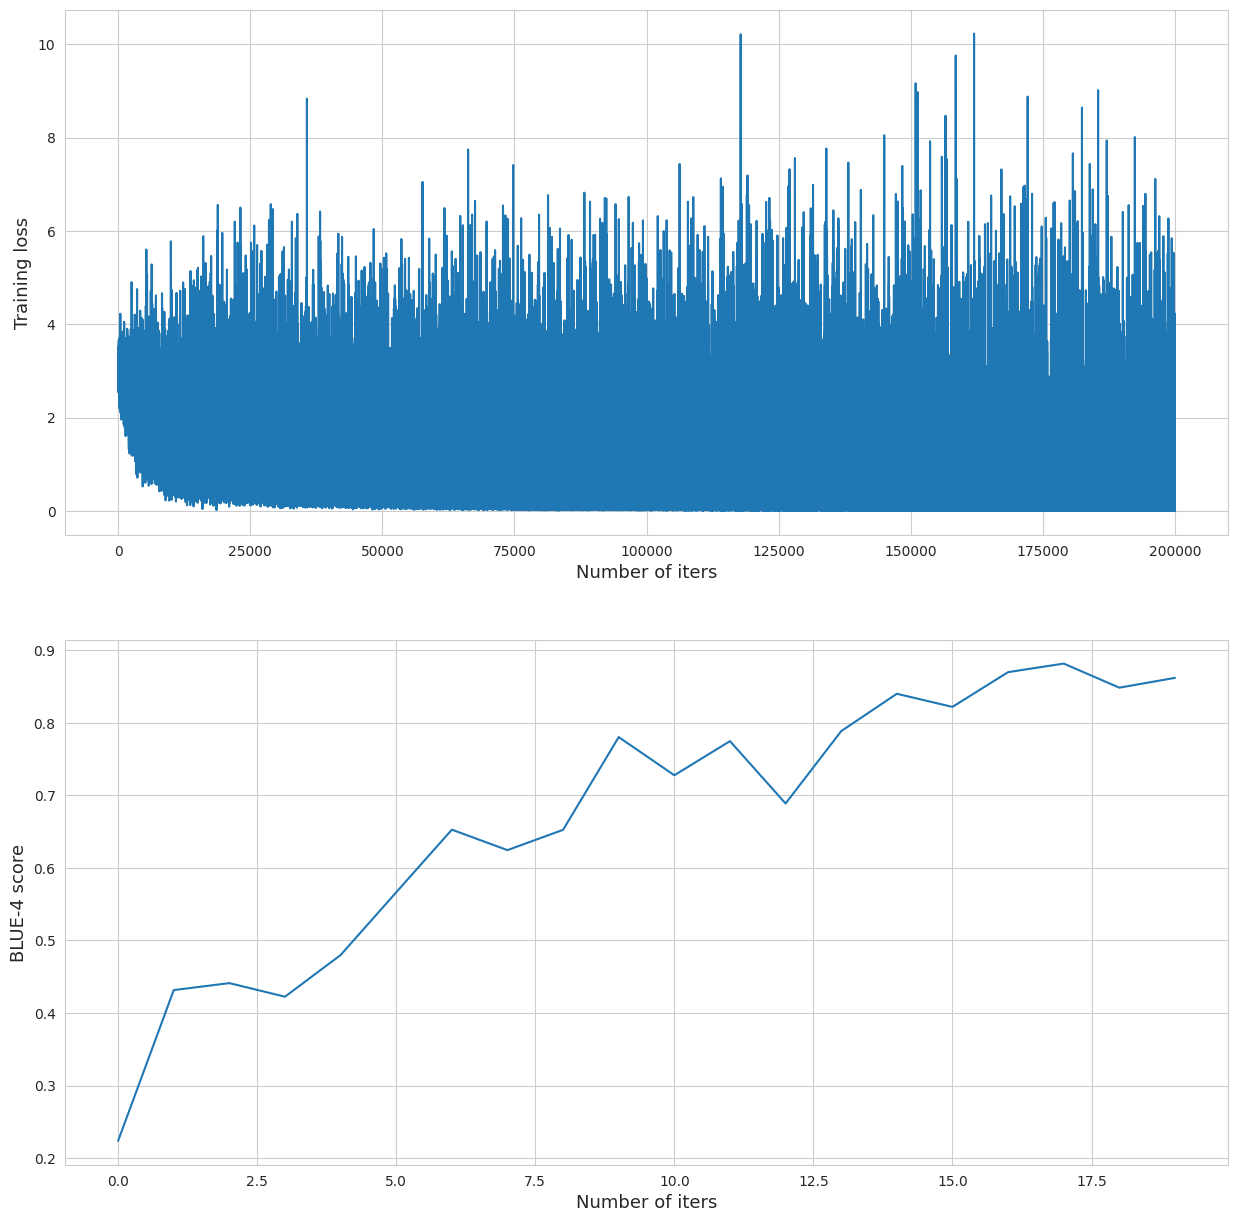

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

score = np.load(
    "/home/deepcat/Documents/Course/DL/DL_Lab3/training_process/testing_bleu4.npy"
)
loss = np.load(
    "/home/deepcat/Documents/Course/DL/DL_Lab3/training_process/training_loss.npy"
)

plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
sns.set_style("whitegrid")
plt.plot(loss)
# plt.title('Training loss curve', fontsize=13)
plt.xlabel("Number of iters", fontsize=13)
plt.ylabel("Training loss", fontsize=13)

plt.subplot(2, 1, 2)
plt.plot(score)
# plt.title('BLUE-4 score testing curve during training', fontsize=13)
plt.xlabel("Number of iters", fontsize=13)
plt.ylabel("BLUE-4 score", fontsize=13)
plt.savefig(f"training_process/training_process.png")
plt.show()